<a href="https://colab.research.google.com/github/ConnnorM/WiDS_2023_Datathon/blob/main/Copy_of_WiDS2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023 WiDS Climate Change Kaggle Competition:
- by Olivia Armstrong and Connor Martindale
- Using Lasso Regression and XGBoost to make time series predictions

#Imports and Basic Data Exploration

**Imports and Loading the Data**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import csv
import pandas as pd
import numpy as np
from plotnine import *
from sklearn import metrics
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso # Logistic Regression Model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier #Decision Tree Model
from sklearn.ensemble import RandomForestRegressor # Random Forest Model
from sklearn.decomposition import PCA #PCA analysis
from sklearn import svm # Support Vector Machine Model
import xgboost as xgb #XG Boost Model
from sklearn.metrics import f1_score


from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, mean_squared_error #more evaluation metrics
from sklearn.model_selection import train_test_split #train test split

from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
#Load the train and test sets
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

**Pre-Cleaning Data Exploration**

In [ ]:
#Check the number of entries and features in each set
print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)

Train Shape:  (103659, 246)
Test Shape:  (31354, 245)


- As expected, the testing set has one less feature: this missing feature is the target variable that we are predicting values for

In [ ]:
#View the first 5 entries in the set to visualize the data
train.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [ ]:
#Create basic summary statistics of the data set
train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,6518.000000,6518.000000,6518.000000,6518.000000,6518.000000,6518.000000,6239.000000,6518.000000,6518.000000,6518.000000,...,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000
mean,3258.500000,0.055225,0.855140,291.630577,21.032410,23.586319,20.208771,21.856447,19.543245,22.178573,...,-1.129267,-8.010826,6.834488,19.325572,-17.661094,-9.915125,-6.335521,15.785739,10.530890,11.403491
std,1881.728859,0.035717,0.031279,126.513845,7.393149,7.244828,6.884334,6.602167,6.216076,7.444619,...,37.418362,36.220839,38.624900,25.320990,31.986905,34.125204,27.107836,25.810011,25.087993,25.122143
min,0.000000,0.000000,0.800000,98.250000,5.960000,9.080000,7.240000,8.100000,7.490000,10.010000,...,-94.570000,-89.940000,-64.870000,-39.280000,-100.560000,-106.080000,-93.980000,-52.610000,-66.110000,-57.610000
25%,1629.250000,0.045455,0.833333,195.872500,14.370000,17.290000,13.850000,15.480000,14.060000,15.150000,...,-27.200000,-33.290000,-20.000000,2.080000,-40.030000,-32.170000,-20.250000,-0.460000,-6.750000,-5.090000
50%,3258.500000,0.045455,0.866667,270.170000,22.650000,25.470000,20.720000,23.030000,19.960000,22.740000,...,-2.900000,-9.230000,2.330000,20.060000,-16.710000,-8.560000,-6.060000,18.490000,11.900000,11.680000
75%,4887.750000,0.090909,0.866667,354.587500,27.810000,30.820000,26.370000,27.930000,25.410000,29.420000,...,25.050000,17.960000,29.080000,35.120000,4.390000,10.440000,11.620000,30.840000,29.040000,29.360000
max,6517.000000,0.090909,0.900000,699.380000,31.730000,33.230000,31.660000,31.580000,29.710000,33.500000,...,113.920000,96.550000,106.420000,91.760000,56.550000,83.890000,64.850000,90.390000,76.890000,88.660000


Notes from .head() and .describe() Functions:
- Latitude and Longitude are mapped to a range of 0 to 1, perhaps using a sigmoid function
- Index begins count at 0
- Features have entries that are both positive and negative numbers


In [ ]:
#Check the data types of variables
train.dtypes

index                                   int64
lat                                   float64
lon                                   float64
startdate                              object
contest-pevpr-sfc-gauss-14d__pevpr    float64
                                       ...   
wind-vwnd-925-2010-16                 float64
wind-vwnd-925-2010-17                 float64
wind-vwnd-925-2010-18                 float64
wind-vwnd-925-2010-19                 float64
wind-vwnd-925-2010-20                 float64
Length: 246, dtype: object

- [startdate] is an object, not a datetime variable, nor is it a numerical value

In [ ]:
#Check dtype of:
#index: make sure that it's an int
#target variable: determine what we are predicting
print("Index Type: ", train['index'].dtype)
print("Output Var Type: ", train['contest-tmp2m-14d__tmp2m'].dtype)

Index Type:  int64
Output Var Type:  float64


#Data Cleaning and Further Dataset Analysis

**Data Cleaning**

To begin, combine the training and test sets (while storing the lengths of each set) into one dataframe. This lessens the number of cleaning operations we must perform.

In [ ]:
trainLen = len(train)
testLen = len(test)
combined = pd.concat([train, test], axis = 0)

In [ ]:
#Changing startdate variable to usable datetime type
combined.startdate = pd.to_datetime(combined.startdate)

In [ ]:
#Creating new columns for separated date information
combined['day'] = combined.startdate.dt.day
combined['month'] = combined.startdate.dt.month
combined['year'] = combined.startdate.dt.year

In [ ]:
#Create Season Label based on the Month in which Data was Recorded
#Winter = 0, Spring = 1, Summer = 2, Autumn = 3
MonthToSeason = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'autumn',
    10: 'autumn',
    11: 'autumn',
    12: 'winter'
}
combined['season'] = combined['month'].apply(lambda x: MonthToSeason[x])

In [ ]:
#Using Lat/Lon info to classify each location by an ID number
combined['unique_location'] = combined.groupby(['lat', 'lon']).ngroup()

#NOTE: groupby().ngroup() = assigns a number 0 to (N groups - 1) to each group

Dummy Variable Creation:

In [ ]:
#Store the season + year Columns Before Creating Dummy Variables
seasonDF = combined['season']
yearDF = combined['year']

In [ ]:
#Creating Dummy Variables for Categorical Variables: season and year
combined = pd.get_dummies(combined, columns = ['season'], drop_first = True)
combined = pd.get_dummies(combined, columns = ['year'], drop_first = True)

In [ ]:
#Bring the Original Columns Back into the Dataframe (for now)
combined = pd.concat([combined, seasonDF, yearDF], axis=1) 

Split the Training and Testing Sets Apart

In [ ]:
train = combined.iloc[:trainLen]
test = combined.iloc[trainLen:]

**Post-Cleaning Data Exploration**

Plot the Data Set According to the Year in which Data is Collected

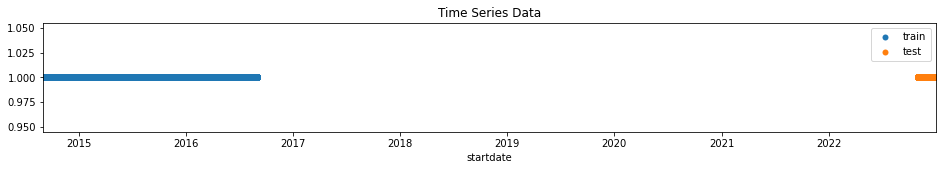

In [ ]:
#From Kaggle Public Code: https://www.kaggle.com/code/iamleonie/wids-datathon-2023-forecasting-with-lgbm
fig, ax = plt.subplots(1,1, figsize=(16,2))
ax.set_title('Time Series Data')
sns.scatterplot(data = train, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'train')
sns.scatterplot(data = test, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'test')
ax.set_xlim([train['startdate'].iloc[0], test['startdate'].iloc[-1]])
plt.show()

- Shows a 5~ year gap in the data between the training and testing sets
- Further indication that we should avoid overfitting to the training set
- Seems to indicate that only certain months are present in the testing set? Yet the training set has a continuous set of data

Examining the Date Ranges of Each Set

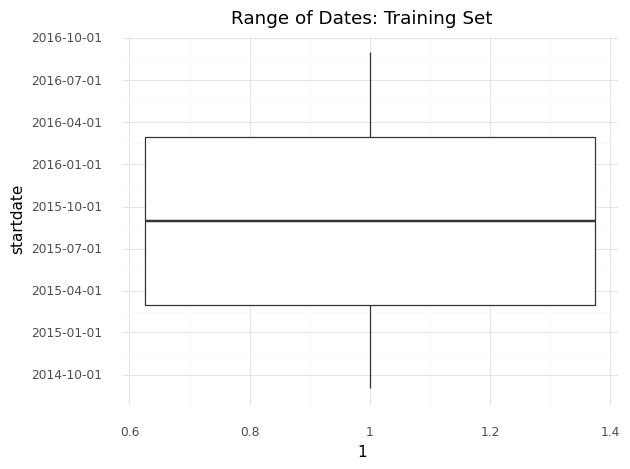

<ggplot: (8788205244606)>

In [ ]:
#Plot the Training Set Range
(ggplot(train, aes(x = 1, y = "startdate")) 
  + geom_boxplot()
  + theme_minimal()
  + ggtitle("Range of Dates: Training Set"))

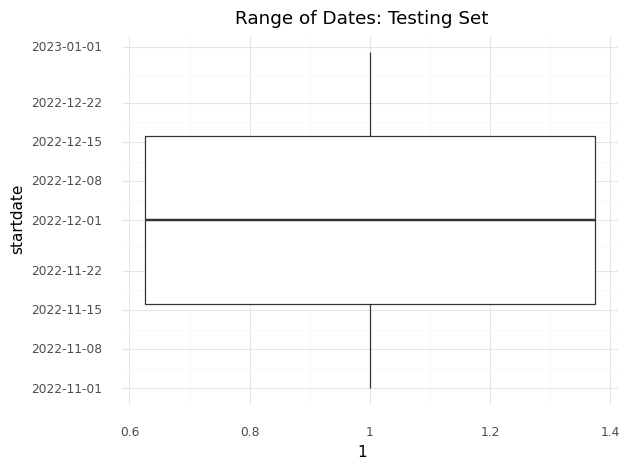

<ggplot: (8788204262280)>

In [ ]:
#Plot the Testing Set Range
(ggplot(test, aes(x = 1, y = "startdate")) 
  + geom_boxplot()
  + theme_minimal()
  + ggtitle("Range of Dates: Testing Set"))

In [ ]:
print("Train Dates:\n", train['startdate'].describe(), '\n')
print("Test Dates:\n", test['startdate'].describe())

Train Dates:
 count                   31354
unique                     61
top       2022-11-01 00:00:00
freq                      514
first     2022-11-01 00:00:00
last      2022-12-31 00:00:00
Name: startdate, dtype: object 

Test Dates:
 count                   31354
unique                     61
top       2022-11-01 00:00:00
freq                      514
first     2022-11-01 00:00:00
last      2022-12-31 00:00:00
Name: startdate, dtype: object


Takeaways:
- Distributions of Training and Testing Set Dates are evenly shaped
- Training Set: September 1, 2014 --> August 31, 2016 (2 full years)
- Testing Set: November 1, 2022 --> December 31, 2022 (2 full months)
- We are only being evaluated on the Testing Set, so perhaps we should experiment with using a less generalizable training set that includes only the months (or seasons) that are present in the testing set (November -> December OR Fall -> Winter)

Examining the Target Variable By Season:

In [ ]:
#Create a new dataframe that gets average temps for each day
avgTempsDF = train.groupby("startdate")['contest-tmp2m-14d__tmp2m'].mean()
avgTempsDF = avgTempsDF.to_frame()
avgTempsDF['startdate'] = avgTempsDF.index

In [ ]:
#Get the season for each date
avgTempsDF.startdate = pd.to_datetime(avgTempsDF.startdate)
avgTempsDF['month'] = avgTempsDF.startdate.dt.month
MonthToSeason = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'autumn',
    10: 'autumn',
    11: 'autumn',
    12: 'winter'
}
avgTempsDF['season'] = avgTempsDF['month'].apply(lambda x: MonthToSeason[x])

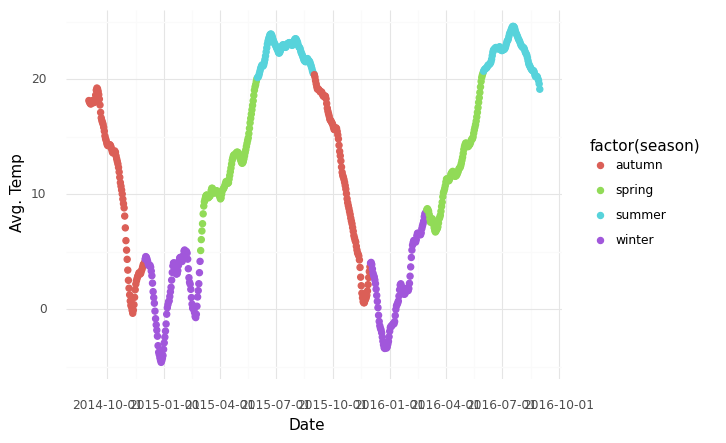

<ggplot: (8756725446241)>

In [ ]:
#Plot the Temperatures by date separated by season
(
    ggplot(avgTempsDF, aes(x='startdate', y='contest-tmp2m-14d__tmp2m', color = "factor(season)"))
    + geom_point(size = 2) # line plot
    + theme_minimal()
    + labs(x='Date', y='Avg. Temp')
)

- Temperature trends seem to be different per season
- Not too much variance between years; overall temps do seem to increase, however

Do we have the same number of entries for each date and location?

In [ ]:
#From Kaggle Public Code: https://www.kaggle.com/code/iamleonie/wids-datathon-2023-forecasting-with-lgbm
train.groupby('startdate')['index'].count()

startdate
2014-09-01    9
2014-09-02    9
2014-09-03    9
2014-09-04    9
2014-09-05    9
             ..
2016-08-27    8
2016-08-28    8
2016-08-29    8
2016-08-30    8
2016-08-31    8
Name: index, Length: 731, dtype: int64

In [ ]:
test.groupby('startdate')['index'].count()

startdate
2022-11-01    86
2022-11-02    86
2022-11-03    86
2022-11-04    86
2022-11-05    86
              ..
2022-12-27    86
2022-12-28    86
2022-12-29    86
2022-12-30    86
2022-12-31    85
Name: index, Length: 61, dtype: int64

- 514 unique values per date = 514 unique locations have data being recorded in the TRAINING SET
- TESTING SET also has 514 unique values; don't necessarily know if they are the same set of 514

In [ ]:
#Check if the 514 locations are the same between sets
print("Total Number of Unique Locations: ", combined['unique_location'].nunique())

Total Number of Unique Locations:  86


- There are 61 locations that are not shared by both sets, yet both sets have 514 total unique locations
- This means that the training set is forcing us to create a generalizable model: we cannot only train the model on the locations present in the testing set since the training set does not have all of these locations

In [ ]:
#Preserving the original, cleaned train/test dataframes in case we need to backtrack
train2 = train
test2 = test

**Dropping Unused Variables**

In [ ]:
#Drop [startdate] since all data has been transformed into other variables
train2 = train2.drop('startdate', axis=1)
test2 = test2.drop('startdate', axis=1)

#Drop [season] since we have dummy variables
train2 = train2.drop('season', axis=1)
test2 = test2.drop('season', axis=1)

#Drop [year] since we have dummy variables
train2 = train2.drop('year', axis=1)
test2 = test2.drop('year', axis=1)

#Drop [unique_location] since it gave us massive overfitting issues
train2 = train2.drop('unique_location', axis = 1)
test2 = test2.drop('unique_location', axis = 1)

#Get rid of the predicted variable in testing set
test2 = test2.drop('contest-tmp2m-14d__tmp2m', axis=1)

Notes on Removing Variables:
- Removed [startdate] since it is represented by the [day], [month], and [year] variables
- Removed [season] and [year] because we have dummy variables for this information now
- [lat] and [lon]: Could be removed since we have now created the [unique_location] variable based on this information. However, [unique_location] will not help us create predictions for the locations that are not in the training set. Therefore, we should keep [lat] and [lon] for their geographic information. This is because locations with similar latitiude and longitude may share similar temperatures, but that direct correlation does not necessarily exist with the [unique_location] labels.
- We need to retain [index] in order to create the submission file in the correct format, but we should not include [index] in the model.
- [day] could be excluded because December 1 and June 1, for example, would have drastically different temperatures. The target variable is linked to the month far more closely than it is to the day of the month. Using this variable could be very misleading.


In [ ]:
#Convert the dummy variables to booleans
convert_dict = {'season_spring': bool,
                'season_summer': bool,
                'season_winter': bool,
                'year_2015': bool,
                'year_2016': bool,
                'year_2022': bool,
                }
 
train2 = train2.astype(convert_dict)
test2 = test2.astype(convert_dict)

In [ ]:
#Check how many variables we have after pre-processing
print("Train: ", train2.shape)
print("Test: ", test2.shape)

Train:  (375734, 253)
Test:  (31354, 252)


#Baseline Lasso Regression: Fully Cleaned Dataset

**Creating a Baseline Lasso Regression Model**
- Lasso Regression automatically applies regularization, providing a more generalizable model than Linear Regression.

In [ ]:
#get rid of null values
train2.dropna(inplace = True)

#split up training predictors and target values
X_train = train2.loc[:, train2.columns != 'contest-tmp2m-14d__tmp2m']
y_train = train2['contest-tmp2m-14d__tmp2m']

#testing data rename
X_test = test2

#exclude object types since regression can't handle them (if any remain)
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

Z-Scoring Numerical Continuous Data

In [ ]:
#Remove the factors that cannot be Z-scored
onlyZvars = X_train.drop(['index',
                        'lat',
                        'lon',
                        'day',
                        'month',
                        'season_spring',
                        'season_summer',
                        'season_winter',
                        'year_2015',
                        'year_2016',
                        'year_2022'], 
                         axis = 1)
features = onlyZvars.columns[:]

In [ ]:
z = StandardScaler()
#don't train on all: only continuous variables, not categoricals

#DON'T FIT ON TEST SET
z.fit(X_train[features])
X_train[features] = z.transform(X_train[features])

X_test[features] = z.transform(X_test[features])

In [ ]:
#Save the finalized testing/training sets that have been Z-scored
cleaned_X_Train = X_train
cleaned_y_Train = y_train
cleaned_X_Test = X_test

In [ ]:
#Save the finalized testing/training sets to be downloaded
cleaned_X_Train.to_csv('X_train_clean.csv', index = False)
cleaned_y_Train.to_csv('y_train_clean.csv', index = False)
cleaned_X_Test.to_csv('X_test_clean.csv', index = False)

print("Your files were successfully saved!")

Lasso Regression

In [ ]:
#model creation and execution
lasso = Lasso()

lasso.fit(X_train, y_train)

print("TRAIN RMSE: ", mean_squared_error(y_train, lasso.predict(X_train), squared = False))

In [ ]:
#create testing set predictions
testPreds = lasso.predict(X_test)

**Saving Predictions in Submission Format**

In [ ]:
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = lasso.predict(X_test)

submission.to_csv('submission_LassoRegBase.csv', index = False)
print("Your submission was successfully saved!")

Baseline Lasso Results:
- Training RMSE: 2.5129070021087467
- Testing RMSE: 12.986

#Baseline Lasso Regression: No Date-Related Data

**Testing Baseline Model without Date-Related Data**

In [ ]:
#Drop Date-Related Data from X_train and X_test
X_trainWOD = X_train.drop(['day',
                        'month',
                        'season_spring',
                        'season_summer',
                        'season_winter',
                        'year_2015',
                        'year_2016',
                        'year_2022'], 
                         axis = 1)
X_testWOD = X_test.drop(['day',
                        'month',
                        'season_spring',
                        'season_summer',
                        'season_winter',
                        'year_2015',
                        'year_2016',
                        'year_2022'], 
                         axis = 1)
y_trainWOD = y_train

In [ ]:
#Train the model
lasso2 = Lasso()
lasso2.fit(X_trainWOD, y_trainWOD)
print("TRAIN RMSE: ", mean_squared_error(y_trainWOD, lasso2.predict(X_trainWOD), squared = False))

In [ ]:
#create testing set predictions and output a submission
submission = pd.read_csv('sample_solution.csv')
display(submission)
submission['contest-tmp2m-14d__tmp2m'] = lasso2.predict(X_testWOD)

submission.to_csv('submission_LassoNoDate.csv', index = False)
print("Your submission was successfully saved!")

Baseline Lasso Without Date-Related Data Results:
- Training RMSE: 2.58662675789208
- Testing RMSE: 13.502

#Baseline Lasso Regression: No Location Data

**Testing Baseline Model without Location Data**

In [ ]:
#Drop Date-Related Data from X_train and X_test
X_trainWOL = X_train.drop(['unique_location'], 
                         axis = 1)
X_testWOL = X_test.drop(['unique_location'], 
                         axis = 1)
y_trainWOL = y_train

In [ ]:
#Train the model
lasso3 = Lasso()
lasso3.fit(X_trainWOL, y_trainWOL)
print("TRAIN RMSE: ", mean_squared_error(y_trainWOL, lasso3.predict(X_trainWOL), squared = False))

TRAIN RMSE:  2.563119010488292


In [ ]:
#create testing set predictions and output a submission
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = lasso3.predict(X_testWOL)

submission.to_csv('submission_LassoNoLoc.csv', index = False)
print("Your submission was successfully saved!")

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738
...,...,...
31349,28.303967,407083
31350,26.635933,407084
31351,27.057762,407085
31352,26.871066,407086


Your submission was successfully saved!


Baseline Lasso Without Location Data Results:
- Training RMSE: 2.563119010488292
- Testing RMSE: 3.107
- We discovered the source of our overfitting issue! The location-related information is causing our data to become incredibly overfit to the training set.
- We tested dropping [lat], [lon], and [unique_location] together as well as only dropping [unique_location], which gave us the exact same set of predictions. Therefore, it would appear that our model is not using [lat] and [lon]  to determine its predictions (the Lasso model is likely eliminating these two variables).

#Baseline Lasso Regression: Only Autumn + Winter Data

**Testing Baseline Model with Only Autumn/Winter Data**

In [ ]:
#Grab only Autumn and Winter Data
#y_train = y_train.to_frame()
trainFull = X_train
trainFull['contest-tmp2m-14d__tmp2m'] = y_train['contest-tmp2m-14d__tmp2m']
trainFull = trainFull.loc[trainFull['season_summer'] != 1]
trainFullAW = trainFull.loc[trainFull['season_spring'] != 1]

y_trainAW = trainFullAW['contest-tmp2m-14d__tmp2m']
X_trainAW = trainFullAW.drop(['contest-tmp2m-14d__tmp2m'], 
                         axis = 1)

testSum = X_test.loc[X_test['season_summer'] != 1]
X_testAW = testSum.loc[testSum['season_spring'] != 1]

In [ ]:
#Train the model
lasso4 = Lasso()
lasso4.fit(X_trainAW, y_trainAW)
print("TRAIN RMSE: ", mean_squared_error(y_trainAW, lasso4.predict(X_trainAW), squared = False))

TRAIN RMSE:  2.7691265590715948


In [ ]:
#create testing set predictions and output a submission
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = lasso4.predict(X_testAW)

submission.to_csv('submission_LassoAutWin.csv', index = False)
print("Your submission was successfully saved!")

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738
...,...,...
31349,28.303967,407083
31350,26.635933,407084
31351,27.057762,407085
31352,26.871066,407086


Your submission was successfully saved!


Baseline Lasso Without Only Winter/Autumn Data Results:
- Training RMSE: 2.7691265590715948
- Testing RMSE: 11.702
- Removing Spring/Summer data from the training set does not seem to improve accuracy, and it reintroduces a serious overfitting problem.

#Baseline Lasso Regression: Only November/December Data

**Testing Baseline Model with Only November/December Data**

In [ ]:
#Grab data from November and December Only
#y_train = y_train.to_frame()
trainFull = X_train
trainFull['contest-tmp2m-14d__tmp2m'] = y_train['contest-tmp2m-14d__tmp2m']
trainFullND = trainFull.loc[trainFull['month'] >= 11]

y_trainND = trainFullND['contest-tmp2m-14d__tmp2m']
X_trainND = trainFullND.drop(['contest-tmp2m-14d__tmp2m'], 
                         axis = 1)

X_testND = X_test.loc[X_test['month'] >= 11]

In [ ]:
#Train the model
lasso5 = Lasso()
lasso5.fit(X_trainND, y_trainND)
print("TRAIN RMSE: ", mean_squared_error(y_trainND, lasso5.predict(X_trainND), squared = False))

TRAIN RMSE:  3.148716778693042


In [ ]:
#create testing set predictions and output a submission
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = lasso5.predict(X_testND)

submission.to_csv('submission_LassoNovDec.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Baseline Lasso Without Only November/December Data Results:
- Training RMSE: 3.148716778693042
- Testing RMSE: 7.008
- It would appear that our idea of only training the model on the 2 months (or 2 seasons) present in the testing set did not help the model. Rather, by eliminating a significant portion of the training set, the model's accuracy lowered, and the model became increasingly overfit.

#Baseline Lasso Regression: Uncleaned Data

**Uncleaned Data with Baseline Lasso Regression**
- NOTE: some data types are being changed such that the regression model does not have to exclude those variables

In [ ]:
#Load the train and test sets
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [ ]:
train = pd.get_dummies(train, columns = ['climateregions__climateregion'], drop_first = True)
test = pd.get_dummies(test, columns = ['climateregions__climateregion'], drop_first = True)

In [ ]:
#Convert startdate variable to a useable type: new columns for day, month, year
train.startdate = pd.to_datetime(train.startdate)
train['day'] = train.startdate.dt.day
train['month'] = train.startdate.dt.month
train['year'] = train.startdate.dt.year
train = train.drop(['startdate'], axis = 1)

test.startdate = pd.to_datetime(test.startdate)
test['day'] = test.startdate.dt.day
test['month'] = test.startdate.dt.month
test['year'] = test.startdate.dt.year
test = test.drop(['startdate'], axis = 1)

In [ ]:
#get rid of null values
train.dropna(inplace = True)

#split up training predictors and target values
X_train = train.loc[:, train.columns != 'contest-tmp2m-14d__tmp2m']
y_train = train['contest-tmp2m-14d__tmp2m']

#testing data rename
X_test = test

#exclude object types since regression can't handle them (if any remain)
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

In [ ]:
lasso6 = Lasso()
lasso6.fit(X_train, y_train)

print("TRAIN RMSE: ", mean_squared_error(y_train, lasso6.predict(X_train), squared = False))

In [ ]:
#Creating the submission
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = lasso6.predict(X_test)

submission.to_csv('submission_LassoRegNoCleaning.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Baseline Lasso with Dropping Nulls and Objects Results:
- Training RMSE: 1.6104603625259848
- Testing RMSE: 1.611
- We have achieved our lowest RMSE score with the baseline model by not cleaning the data.
- The model is also no longer significantly overfit to the training set.

As a result of our baseline model testing, it would appear that **our data-cleaning efforts ultimately lowered the efficacy of our model.** Therefore, we will use the dataset in its original form for the training of our final XGBoost model.

In [ ]:
#Output the final version of the training and testing sets:
X_train.to_csv('X_train_clean.csv', index = False)
y_train.to_csv('y_train_clean.csv', index = False)
X_test.to_csv('X_test_clean.csv', index = False)

print("Your files were successfully saved!")

Your files were successfully saved!


# Random Forest Model

- A Random Forest model to compare against our Lasso Regression
- Provides additional baseline information before more complex machine learning techniques are used

In [ ]:
#Load the finalized train and test sets
X_train = pd.read_csv('X_train_clean.csv')
y_train = pd.read_csv('y_train_clean.csv')
X_test = pd.read_csv('X_test_clean.csv')

In [ ]:
#Fit the model
#n_estimators = 100 default

randForest = RandomForestRegressor(max_depth = 5, random_state = 0)
randForest.fit(X_train, y_train)

In [ ]:
#Create training set predictions
print("TRAIN RMSE: ", mean_squared_error(y_train, randForest.predict(X_train), squared = False))

TRAIN RMSE:  2.4108631622777126


In [ ]:
#Creating the submission
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = randForest.predict(X_test)

submission.to_csv('submission_RandForest.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Baseline Random Forest Regression:
- Training RMSE: 2.4108631622777126
- Testing RMSE: 2.459
- Overall worse than the Lasso model
- Does not appear to be overfitting at all to the training set

# Principal Component Analysis

**Principal Component Analysis**
- A regularization technique: combines factors with overlapping information 
- EX: [month] and [season] likely contain similar information for the model, so these factors may be united to form one variable by the PCA.

In [ ]:
#Load the finalized train and test sets
X_train = pd.read_csv('X_train_clean.csv')
y_train = pd.read_csv('y_train_clean.csv')
X_test = pd.read_csv('X_test_clean.csv')

In [ ]:
#Convert the dummy variables to booleans
convert_dict = {'climateregions__climateregion_BSk': bool,
                'climateregions__climateregion_BWh': bool,
                'climateregions__climateregion_BWk': bool,
                'climateregions__climateregion_Cfa': bool,
                'climateregions__climateregion_Cfb': bool,
                'climateregions__climateregion_Csa': bool,
                'climateregions__climateregion_Csb': bool,
                'climateregions__climateregion_Dfa': bool,
                'climateregions__climateregion_Dfb': bool,
                'climateregions__climateregion_Dfc': bool,
                'climateregions__climateregion_Dsb': bool,
                'climateregions__climateregion_Dsc': bool,
                'climateregions__climateregion_Dwa': bool,
                'climateregions__climateregion_Dwb': bool
                }
 
X_train = X_train.astype(convert_dict)
X_test = X_test.astype(convert_dict)

Z-Score Continuous, Numerical Data before PCA

In [ ]:
#Remove the factors that cannot be Z-scored
onlyZvars = X_train.drop(['index',
                'lat',
                'lon',
                'day',
                'month',
                'year',
                'climateregions__climateregion_BSk',
                'climateregions__climateregion_BWh',
                'climateregions__climateregion_BWk',
                'climateregions__climateregion_Cfa',
                'climateregions__climateregion_Cfb',
                'climateregions__climateregion_Csa',
                'climateregions__climateregion_Csb',
                'climateregions__climateregion_Dfa',
                'climateregions__climateregion_Dfb',
                'climateregions__climateregion_Dfc',
                'climateregions__climateregion_Dsb',
                'climateregions__climateregion_Dsc',
                'climateregions__climateregion_Dwa',
                'climateregions__climateregion_Dwb'], 
                         axis = 1)
features = onlyZvars.columns[:]
z = StandardScaler()
#don't train on all: only continuous variables, not categoricals

z.fit(X_train[features])
X_train[features] = z.transform(X_train[features])

X_test[features] = z.transform(X_test[features])

In [ ]:
#Trying with all variables Z-scored and no dummies

#Remove the factors that cannot be Z-scored
onlyZvars = X_train.drop(['index'], 
                         axis = 1)
features = onlyZvars.columns[:]
z = StandardScaler()
#don't train on all: only continuous variables, not categoricals

z.fit(X_train[features])
X_train[features] = z.transform(X_train[features])

X_test[features] = z.transform(X_test[features])

Determine the Optimal Number of Principal Components

In [ ]:
#define and fit the model
pca = PCA()
pca.fit(X_train[features])

PCA()

In [ ]:
X_train[features].shape

(352604, 259)

In [ ]:
#exp1_var: for each component, how much variance does it account for
#changes depending on how many components you have
#cumulative variance: how much variance does first x components account for total
pcaDF = pd.DataFrame({"expl_var" :
                      pca.explained_variance_ratio_,
                      "pc": range(1,260),
                      "cum_var":
                      pca.explained_variance_ratio_.cumsum()})
#Note: range is 1 to (N+1) where N is the number of columns in the dataset when the PCA model is trained

In [ ]:
print(pcaDF.iloc[40:45])

    expl_var  pc   cum_var
40  0.004006  41  0.897787
41  0.003991  42  0.901778
42  0.003944  43  0.905722
43  0.003893  44  0.909615
44  0.003876  45  0.913491


- 41 PCs give us an explanation of 90% of the variance in the dataset
- Far fewer predictors to use than the original 260 columns

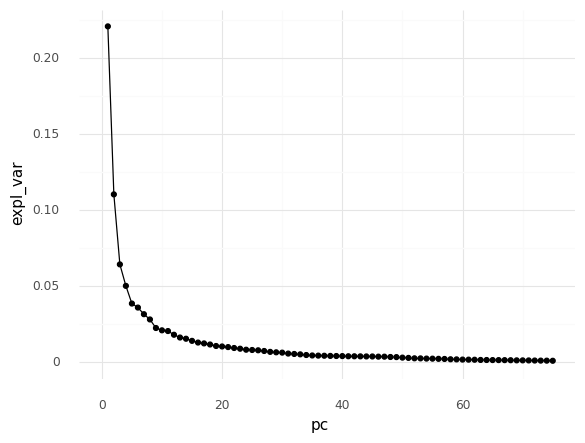

<ggplot: (8760507981331)>

In [ ]:
#elbow method: look at point of inflection of graph: keep up to that
#number component
(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) 
  + geom_line() 
  + geom_point()
  + theme_minimal()
  + xlim(0,75))

- indicates that we should use around 13~ PCs as opposed to the 41 PCs recommended by the other method
- We will use 41 PCs since they provide us with more data than only 13 (later testing reveals that using 41 PCs did not overfit the model)

In [ ]:
#grab first 41 because they explain 90% of the variance
pcomps41 = pca.transform(X_train[features])
pcomps41 = pd.DataFrame(pcomps41[:, 0:40])

In [ ]:
#Baseline Lasso Model:
lasso7 = Lasso()
lasso7.fit(X_train[features], y_train)

print("TRAIN RMSE: ", mean_squared_error(y_train, lasso7.predict(X_train[features]), squared = False))

TRAIN RMSE:  2.5983658955952813


In [ ]:
#Creating the submission
submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = lasso7.predict(X_test[features])

submission.to_csv('submission_LassoRegPCA.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Baseline Lasso with PCA (41 PCs):
- Training RMSE: 2.5983658955952813
- Testing RMSE: 2.026
- Since the testing RMSE is lower than the training RMSE, this is the most generalizable model we have. However, its overall performance is still worse than that of the Lasso model that does not use PCA.

#XGBoost Model

**XG Boost Model**

Parameter Details:
  
*  Base_score: Default is 0.5, initial prediction score of all instances (basically does not really matter)
*   Booster: Type of model to run at each iteration, two options:
  - gbtree = tree-based model
  - gblinear = linear model
*   N_estimators: Number of runs XGBoost will try to learn, default is usually 100
*   Early_stopping_rounds: Monitors performance of model that is being trained on a seperate test dataset and stops training procedure once performance on test dataset has not improved after a fixed # of iterations
*   Objective: Loss function to be minimized
*   Max_depth: Makes splits up until this point before pruning the tree backwards and remove splits beyond which there is no positive gain, used to control overfitting, typical values 3-10
*   Learning_rate: Shrinkage we do at every step, default 0.01


There are a lot more, but these are the basic ones, depending on RSME we can experiment with those









XGBoost W/ RandomizedSearchCV

In [ ]:
X_train = pd.read_csv('X_train_clean.csv')
y_train = pd.read_csv('y_train_clean.csv')
X_test = pd.read_csv('X_test_clean.csv')

In [ ]:
# Create Model
import xgboost
classifier = xgboost.XGBRegressor()

In [ ]:
# Parameter Dictionary
param_dict = OrderedDict()
param_dict['max_depth'] = [5, 10, 15, 20, 25]
param_dict['subsample'] = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_dict['colsample_bytree'] = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_dict['learning_rate'] = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40]
param_dict['gamma'] = [0.00, 0.05, 0.10, 0.15, 0.20]
param_dict['scale_pos_weight'] = [30, 40, 50, 300, 400, 500, 600, 700]

In [ ]:
# Model Building
rs_model=RandomizedSearchCV(classifier,param_distributions=param_dict,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [ ]:
# Fit
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[22:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions=OrderedDict([('max_depth',
                                                     [5, 10, 15, 20, 25]),
                                                    ('subsample',
                                                     [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]),
                                                    ('colsample_bytree',
                                                     [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]),
                                                    ('learning_rate',
                                                     [0.01, 0.05, 0.1, 0.2, 0.3,
                                                      0.4]),
                                                    ('gamma',
                                                     [0.0, 0.05, 0.1, 0.15,
                  

In [ ]:
rs_model.best_estimator_

XGBRegressor(colsample_bytree=0.8, gamma=0.1, max_depth=25, scale_pos_weight=50,
             subsample=0.7)

In [ ]:
# Create Model w/ Optimized Parameters

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=50000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       eval_metric = 'rmse',
                       colsample_bytree=0.8,
                       gamma = 0.1,
                       max_depth=25,
                       scale_pos_weight=50,
                       min_child_weight = 1,
                       subsample=0.7,
                       learning_rate=0.01, 
                       gpu_id=0)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_train, y_train)],
        verbose=100)

[18:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.6231	validation_1-rmse:14.6231
[100]	validation_0-rmse:5.42609	validation_1-rmse:5.42609
[200]	validation_0-rmse:2.04088	validation_1-rmse:2.04088
[300]	validation_0-rmse:0.788651	validation_1-rmse:0.788651
[400]	validation_0-rmse:0.321563	validation_1-rmse:0.321563
[500]	validation_0-rmse:0.149712	validation_1-rmse:0.149712
[600]	validation_0-rmse:0.092468	validation_1-rmse:0.092468


Performed very well on training set, score on Kaggle shows model is very much overfit

In [ ]:
pred = reg.predict(X_test)
print(pred.shape)

(31354,)


In [ ]:
#Creating the submission

submission = pd.read_csv('sample_solution.csv')
submission['contest-tmp2m-14d__tmp2m'] = reg.predict(X_test)

submission.to_csv('submission_XGBoostwRS.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


XGBoost W/ RandomizedSearchCV & Clean final dataset

In [ ]:
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')

In [ ]:
# Parameter Dictionary
param_dict = OrderedDict()
param_dict['max_depth'] = [5, 10, 15, 20, 25]
param_dict['subsample'] = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_dict['colsample_bytree'] = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_dict['learning_rate'] = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40]
param_dict['gamma'] = [0.00, 0.05, 0.10, 0.15, 0.20]
param_dict['scale_pos_weight'] = [30, 40, 50, 300, 400, 500, 600, 700]

In [ ]:
# Model Building
rs_model2=RandomizedSearchCV(classifier,param_distributions=param_dict,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [ ]:
# Fit
rs_model2.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
rs_model2.best_estimator_

In [ ]:
# Create Model w/ Optimized Parameters

reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       colsample_bytree=0.8,
                       gamma = 0.1,
                       max_depth=25,
                       scale_pos_weight=50,
                       min_child_weight = 1,
                       subsample=0.7,
                       learning_rate=0.01)

reg2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_train, y_train)],
        verbose=100)

- Validation Set RMSE: 0.068
- Testing Set RMSE: 2.294
- The model is quite overfit to the training set, yet its overall accuracy surpasses that of the Random Forest model